# Generate Interanual tDOC nutrient runoff forcing

In [1]:
import numpy as np
import pandas as pd
from MITgcmutils import mds
import matplotlib.pyplot as plt

In [4]:
######### Parameters #########
# tDOC distribution
ldoc = 44
rdoc = 44
cdom = 12

## II. Read tDOC data

In [6]:
Sha_df = pd.read_csv(DatIn_pth+'tDOC_Shallow.csv', sep=';')
Sha_df = Sha_df.set_index(pd.DatetimeIndex(Sha_df['Date']))[['Cont Load Est (kgC/d)']]
Bel_df = pd.read_csv(DatIn_pth+'tDOC_Beluga.csv', sep=';')
Bel_df = Bel_df.set_index(pd.DatetimeIndex(Bel_df['Date']))[['Cont Load Est (kgC/d)']]
Kug_df = pd.read_csv(DatIn_pth+'tDOC_Kugmallit.csv', sep=';')
Kug_df = Kug_df.set_index(pd.DatetimeIndex(Kug_df['Date']))[['Cont Load Est (kgC/d)']]

In [7]:
Date = Sha_df.index
Date_yr = Date[(Date.month==1)&(Date.day==1)]

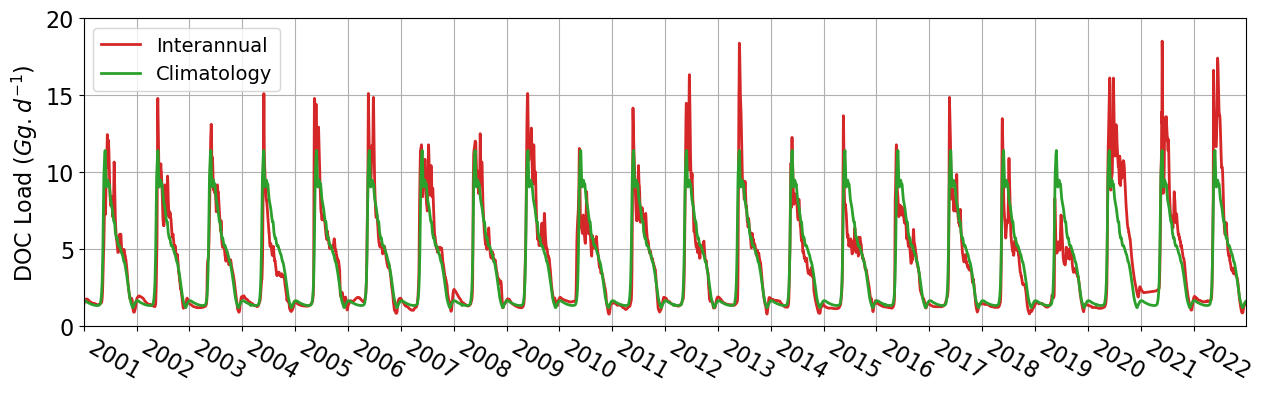

In [10]:
# Plot

### b. Convert Load from $kg.d^{-1}$ to $mmol.s^{-1}$

In [11]:
def convLd(LdIn):
    Mm = 12.0107
    d2s = 24*3600
    # Convert from kg/d to mmol/s
    LdOut = (LdIn*1e6)/(Mm*d2s)
    return(LdOut)

In [12]:
Bay_ls = ['Ld_Sha','Ld_Bel', 'Ld_Kug'] # order of variable is important inlet 1=Shalow, etc.. 
for i in range(len(Bay_ls)):
    globals()[Bay_ls[i]+'an'] = convLd(globals()[Bay_ls[i][-3:]+'_df']['Cont Load Est (kgC/d)'].values)
    Clm_temp = globals()[Bay_ls[i][-3:]+'_df'].groupby([globals()[Bay_ls[i][-3:]+'_df'].index.month,
                                                        globals()[Bay_ls[i][-3:]+'_df'].index.day]).mean().values
    globals()[Bay_ls[i]+'Clim'] = convLd(Clm_temp[:,0])

### c. Read Mac270 grid data

In [ ]:
# read mac270 grid
XC = mds.rdmds('XC')
YC = mds.rdmds('YC')
Vol = mds.rdmds('rAc')*mds.rdmds('dRF')[0]
MaskC = mds.rdmds('maskInC')

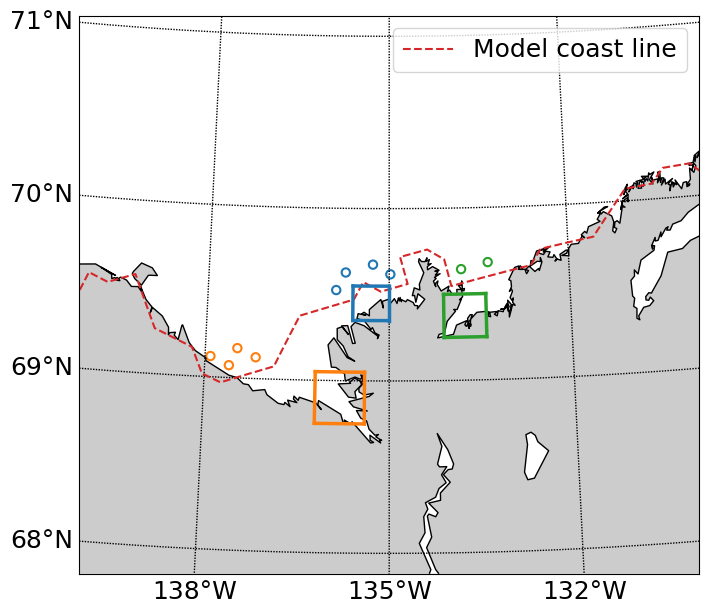

In [16]:
# Below are two ED-SBS matrixes with frocing
# cells positions and discharge distribution
# See plot below
inlet = np.load(MacIn_pth+'Inlets_'+dist+'.npy')

## IV. Create forcing matrixes

$r[mmol.m^{-3}.s^{-1}] = r[mmol.s^{-1}]*W$ 

where $W = \frac{1}{V.N}$ with:
- V = cell volume
- N = Number of entry cells for the outlet

## a. Interannual forcing

In [17]:
# Create the W matrix
id_inlet = np.where(inlet>0)
N = np.ones(inlet.shape)
for i in range(int(inlet.max())):
    N[np.where(inlet==i+1)] = list(inlet[id_inlet]).count(i+1)
W = 1/(Vol*N)
W_exp = np.repeat(np.expand_dims(W,axis=0), len(Ld_Shaan),axis=0)

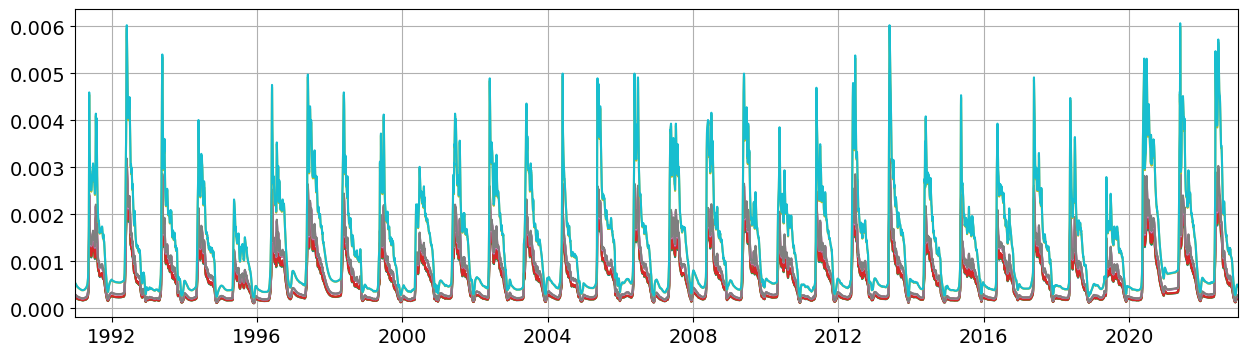

In [19]:
# Compute the runoff matrix
DOCan_mac270 = np.zeros((len(Date),XC.shape[0],XC.shape[1]))
for j in range(len(id_inlet[0])):
    Ld_temp = globals()[Bay_ls[int(inlet[id_inlet[0][j],id_inlet[1][j]])-1]+'an']
    DOCan_mac270[:,id_inlet[0][j],id_inlet[1][j]] = Ld_temp*W_exp[:,id_inlet[0][j],id_inlet[1][j]]
del Ld_temp

In [24]:
def bin_save(fnm, array):
    newFile = open(fnm, "wb")
    bitearray = pack(">%sf" % len(array.flatten()),*array.flatten())
    newFile.write(bitearray);

In [27]:
if ch =='y': 
    for yr in list(set(Date.year)):
        ############ Refractory ############    
        bin_save(Out_int_pth+"tDOCr/tDOCr_runoff_mac270_"+str(yr), DOCan_mac270[np.where(Date.year==yr)]*rdoc*1e-2)
        ############ Labile ############
        bin_save(Out_int_pth+"tDOCl/tDOCl_runoff_mac270_"+str(yr), DOCan_mac270[np.where(Date.year==yr)]*ldoc*1e-2)
        ############ CDOM ############
        if cdom > 0:
            bin_save(Out_int_pth+"tDOCc/tDOCc_runoff_mac270_"+str(yr), DOCan_mac270[np.where(Date.year==yr)]*cdom*1e-2)